In [1]:
import os
# use CPU
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
# use GPU 0,1
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
import resource
import numpy as np
from skimage import img_as_bool, io, color

thickTrainDir = "data_wave/train/thick/"
thinTrainDir = "data_wave/train/thin/"
thickValDir = "data_wave/validation/thick/"
thinValDir = "data_wave/validation/thin/"

X_train = []
y_train = []
X_val = []
y_val = []

# se leen todas la imagenes de un directorio, se convierten en matriz y se guardan en imglist
# el tipo de imagen se guarda en labels
def appendImgs(imglist, labels, directory):
    imgs = os.listdir(directory)
    for img in imgs:
        imgPath = directory + img
        if not os.path.isdir(imgPath) :
            x = load_img(imgPath)
            x = img_as_bool(color.rgb2gray(io.imread(imgPath)))
            imglist.append(x)
            if 'thick' in imgPath:
                labels.append(1)
            elif 'thin' in imgPath:
                labels.append(0)

appendImgs(X_train, y_train, thickTrainDir)
appendImgs(X_train, y_train, thinTrainDir)

appendImgs(X_val, y_val, thickValDir)
appendImgs(X_val, y_val, thinValDir)

X_train = np.array(X_train).astype(int)
y_train = np.array(y_train)

X_val = np.array(X_val).astype(int)
y_val = np.array(y_val)

#X_train.shape

print('X_train.shape = ', X_train.shape)
print('y_train.shape = ', y_train.shape)

print('X_val.shape = ', X_val.shape)
print('y_val.shape = ', y_val.shape)



Using TensorFlow backend.
/home/aalejo/anaconda3/envs/iaenv/lib/python3.7/site-packages/skimage/util/dtype.py:131: UserWarning: Possible sign loss when converting negative image of type float64 to positive image of type bool.
  .format(dtypeobj_in, dtypeobj_out))
/home/aalejo/anaconda3/envs/iaenv/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to bool
  .format(dtypeobj_in, dtypeobj_out))


X_train.shape =  (2000, 256, 256)
y_train.shape =  (2000,)
X_val.shape =  (400, 256, 256)
y_val.shape =  (400,)


Text(0.5, 1.0, 'Fibra delgada (4px)')

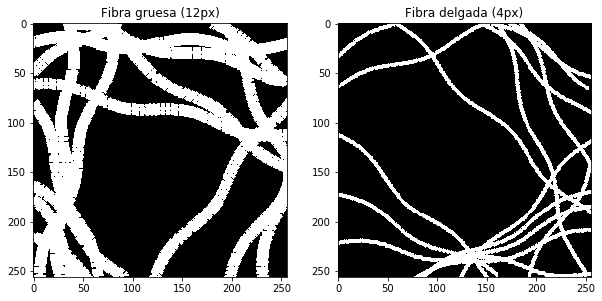

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

random_image_thick = random.randint(0, X_train.shape[0]/2-1)
random_image_thin = random.randint(X_train.shape[0]/2,X_train.shape[0])

#plt.imshow(X_train[random_image_thick],cmap='gray')
#plt.show()
#plt.imshow(X_train[random_image_thin],cmap='gray')


fig, axs = plt.subplots(1, 2, figsize=(10,10))

axs[0].imshow(X_train[random_image_thick],cmap='gray')
axs[0].set_title("Fibra gruesa (12px)")
axs[1].imshow(X_train[random_image_thin],cmap='gray')
axs[1].set_title("Fibra delgada (4px)")

#print(X_train[random_image_thick])


In [4]:
#import keras
from tensorflow import keras
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, AveragePooling2D, BatchNormalization
from keras.regularizers import l2
import tensorflow as tf

print('version de tensorflow')
print(tf.__version__)

tf.keras.backend.clear_session()

#config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True
#session = tf.compat.v1.Session(config=config)

NUM_CLASSES = 2
#NUM_FILTERS = 128
#NUM_FILTERS = 32

#bs = 32
#epochs = 10
#lr = 0.001

#model = Sequential()
#model.add(Flatten(input_shape=X_train[0].shape))
#model.add(Dense(128, activation='relu'))
#model.add(Dense(2, activation='softmax'))
#model.compile(optimizer=SGD(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model.summary()

REGU_L2 = 0.01

X_train = X_train.reshape(X_train.shape[0], 256, 256, 1)
X_val = X_val.reshape(X_val.shape[0], 256, 256, 1)


input_shape = (256, 256, 1)

#print('X_train.shape:', X_train.shape)

model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5), activation='relu', use_bias=False, kernel_regularizer=l2(l=REGU_L2), input_shape=input_shape))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(AveragePooling2D(pool_size=(4, 4)))

model.add(Conv2D(64, (5, 5), activation='relu',use_bias=False,kernel_regularizer=l2(l=REGU_L2)))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(AveragePooling2D(pool_size=(4, 4)))

#model.add(Conv2D(64, (5, 5), activation='relu',use_bias=False,kernel_regularizer=l2(l=REGU_L2)))
#model.add(BatchNormalization())
#model.add(AveragePooling2D(pool_size=(4, 4)))

model.add(Dropout(0.25))

model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation='relu',kernel_regularizer=l2(l=REGU_L2)))

model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid',kernel_regularizer=l2(l=REGU_L2)))


#optimizer = Adam(lr=0.001,decay=0.0)
optimizer = SGD(lr=0.001,momentum=0.9)

model.compile(optimizer=optimizer,
              #loss='sparse_categorical_crossentropy', 
              loss='binary_crossentropy', 
              metrics=['acc'])

model.summary()


version de tensorflow
2.0.0
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 252, 252, 32)      800       
_________________________________________________________________
batch_normalization_1 (Batch (None, 252, 252, 32)      128       
_________________________________________________________________
average_pooling2d_1 (Average (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 64)        51200     
_________________________________________________________________
batch_normalization_2 (Batch (None, 59, 59, 64)        256       
_________________________________________________________________
average_pooling2d_2 (Average (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)       

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#BATCH_SIZE = 8
BATCH_SIZE = 1

EPOCHS = 15

log = model.fit(x=X_train,y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val), verbose=1)


Train on 2000 samples, validate on 400 samples
Epoch 1/15
2000/2000 [==============================] - 26s 13ms/step - loss: 3.2738 - acc: 0.8495 - val_loss: 2.3673 - val_acc: 0.8250
Epoch 2/15
2000/2000 [==============================] - 22s 11ms/step - loss: 1.4797 - acc: 0.9910 - val_loss: 1.2016 - val_acc: 0.9075
Epoch 3/15
2000/2000 [==============================] - 23s 12ms/step - loss: 0.7068 - acc: 0.9980 - val_loss: 0.6379 - val_acc: 0.9300
Epoch 4/15
2000/2000 [==============================] - 23s 11ms/step - loss: 0.3425 - acc: 0.9990 - val_loss: 0.7736 - val_acc: 0.7200
Epoch 5/15
2000/2000 [==============================] - 23s 12ms/step - loss: 0.1705 - acc: 1.0000 - val_loss: 0.2249 - val_acc: 0.9575
Epoch 6/15
2000/2000 [==============================] - 23s 11ms/step - loss: 1.0539 - acc: 0.7300 - val_loss: 1.7745 - val_acc: 0.5200
Epoch 7/15
2000/2000 [==============================] - 23s 12ms/step - loss: 1.5811 - acc: 0.5190 - val_loss: 1.3470 - val_acc: 0.5175
E

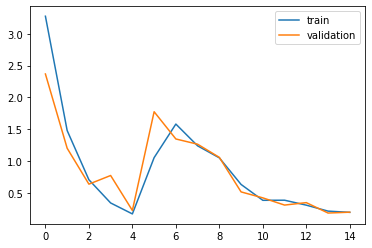

In [6]:
plt.plot(log.history['loss'], label='train')
plt.plot(log.history['val_loss'], label='validation')
#plt.plot(log.history['accuracy'], label='train')
#plt.plot(log.history['val_accuracy'], label='validation')
plt.legend()

In [7]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.19758684754371644
Test accuracy: 0.9850000143051147


In [8]:
model.save("model.h5")
print("Saved model to disk")

Saved model to disk


In [9]:
img_width,img_height = 256,256
#img = load_img('data/validation/thick/0001.png',False,target_size=(img_width,img_height))

test_dir = "data/test/"

test_imgs = os.listdir(test_dir)
predicciones = []
imagenes = []
for img in test_imgs:
    imgPath = test_dir + img
    if not os.path.isdir(imgPath) :
        imgBool = img_as_bool(color.rgb2gray(io.imread(imgPath)))
        imagenes.append(imgBool)
        
        x = img_to_array(imgBool)
        x = np.expand_dims(x, axis=0)
        clases = model.predict_classes(x)
        clase = None
        if 1 in clases:
            clase = "Fibra gruesa"
        elif 0 in clases:
            clase = "Fibra delgada"
        predicciones.append(clase)
        print(img, " es ", clase)


#img = img_as_bool(color.rgb2gray(io.imread('data/test/0001.png')))
#x = img_to_array(img)
#x = np.expand_dims(x, axis=0)
#preds = model.predict_classes(x)
#prob = model.predict_proba(x)
#print(preds, prob)
#preds

/home/aalejo/anaconda3/envs/iaenv/lib/python3.7/site-packages/skimage/util/dtype.py:131: UserWarning: Possible sign loss when converting negative image of type float64 to positive image of type bool.
  .format(dtypeobj_in, dtypeobj_out))
/home/aalejo/anaconda3/envs/iaenv/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to bool
  .format(dtypeobj_in, dtypeobj_out))


0020.png  es  Fibra delgada
0001.png  es  Fibra gruesa
0014.png  es  Fibra gruesa
0011.png  es  Fibra gruesa
0002.png  es  Fibra delgada
0004.png  es  Fibra delgada
0009.png  es  Fibra gruesa
0015.png  es  Fibra gruesa
0017.png  es  Fibra gruesa
0006.png  es  Fibra delgada
0003.png  es  Fibra delgada
0013.png  es  Fibra gruesa
0007.png  es  Fibra delgada
0008.png  es  Fibra gruesa
0012.png  es  Fibra gruesa
0019.png  es  Fibra gruesa
0005.png  es  Fibra delgada
0018.png  es  Fibra gruesa
0016.png  es  Fibra gruesa
0010.png  es  Fibra gruesa


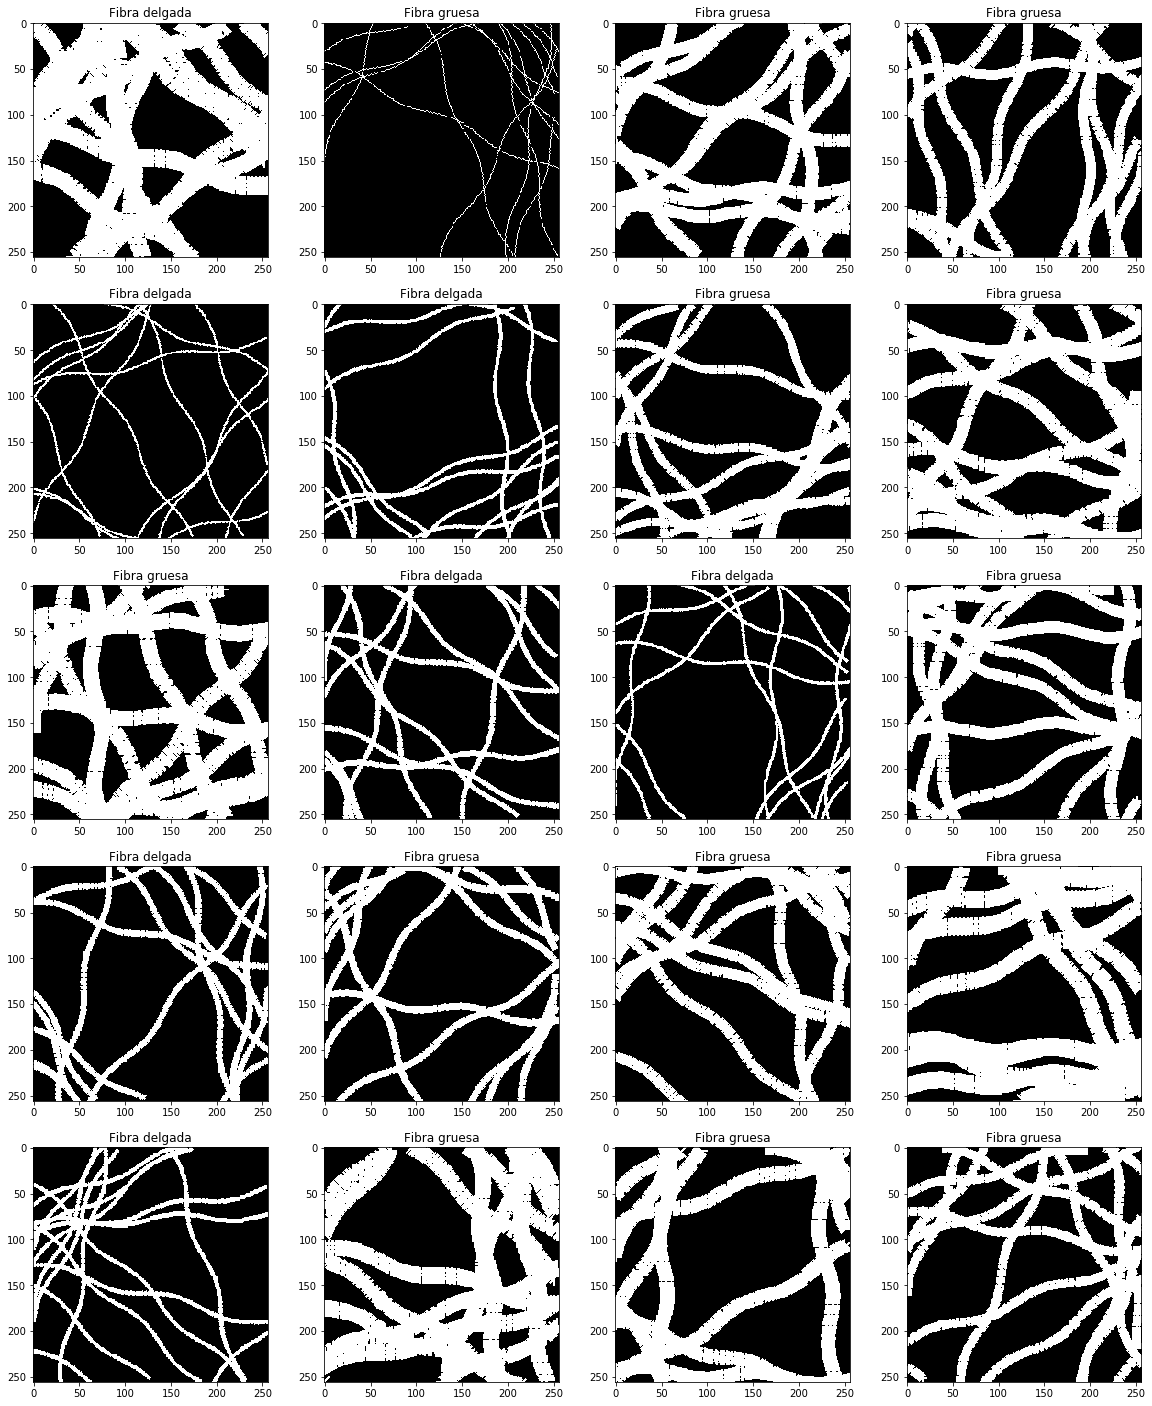

In [10]:
import math

#img = img_as_bool(color.rgb2gray(io.imread('data/test/0001.png')))
#x = img_to_array(img)
#x = np.array(img)
#plt.imshow(x)

filas = math.ceil(len(imagenes)/4)
fig, axs = plt.subplots(filas, 4, figsize=(20,25))

fila = 0
col = 0

for k, img in enumerate(imagenes):
    
    col = col % 4
    
    axs[fila, col].imshow(np.array(img),cmap='gray')
    axs[fila, col].set_title(predicciones[k])
    
    col+=1
    
    if col == 4:
        fila+=1
    

#axs[0].imshow(X_train[random_image_thick],cmap='gray')
#axs[0].set_title("Fibra gruesa (12px)")
#axs[1].imshow(X_train[random_image_thin],cmap='gray')
#axs[1].set_title("Fibra delgada (4px)")
